In [37]:
import spatialdata as sd
import spatialdata_plot
from spatialdata import transform
import scanpy as sc

import matplotlib.pyplot as plt

from shapely.geometry import Point

In [4]:
sdata = sd.SpatialData.read('/rsrch8/home/biostatistics/lliu12/projects/scpoli/raw/xenium/lung_5k/interm/temp/sdata_pollutant_xenium5k.zarr')
sdata

version mismatch: detected: RasterFormatV02, requested: FormatV04
/usr/local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04


/usr/local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /rsrch8/home/biostatistics/lliu12/projects/scpoli/raw/xenium/lung_5k/interm/temp/sdata_pollutant_xenium5k.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 43270, 26720), (3, 21635, 13360), (3, 10817, 6680), (3, 5408, 3340), (3, 2704, 1670)
│     └── 'morphology_focus': DataTree[cyx] (5, 37348, 54086), (5, 18674, 27043), (5, 9337, 13521), (5, 4668, 6760), (5, 2334, 3380)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (37348, 54086), (18674, 27043), (9337, 13521), (4668, 6760), (2334, 3380)
│     └── 'nucleus_labels': DataTree[yx] (37348, 54086), (18674, 27043), (9337, 13521), (4668, 6760), (2334, 3380)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'anthracosis_regions': GeoDataFrame shape: (261, 1) (2D shapes)
│     ├── 'cell_boundaries': GeoDataFrame shape: (278328, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (278328, 2) (2D shapes)
│     └── 'nucleus_b

##### sdata['table_ann'] has the AnnData object with cell type annotation in .obs['cell_type_major'] (labal transfered by ingest from scanpy)

In [5]:
# Get the annotated data
adata = sdata['table_ann']

# dimension 275556 (cell) × 4621 (gene)
# some genes been excluded during matching the genes in sc reference

/tmp/ipykernel_1168/3328830843.py:24: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


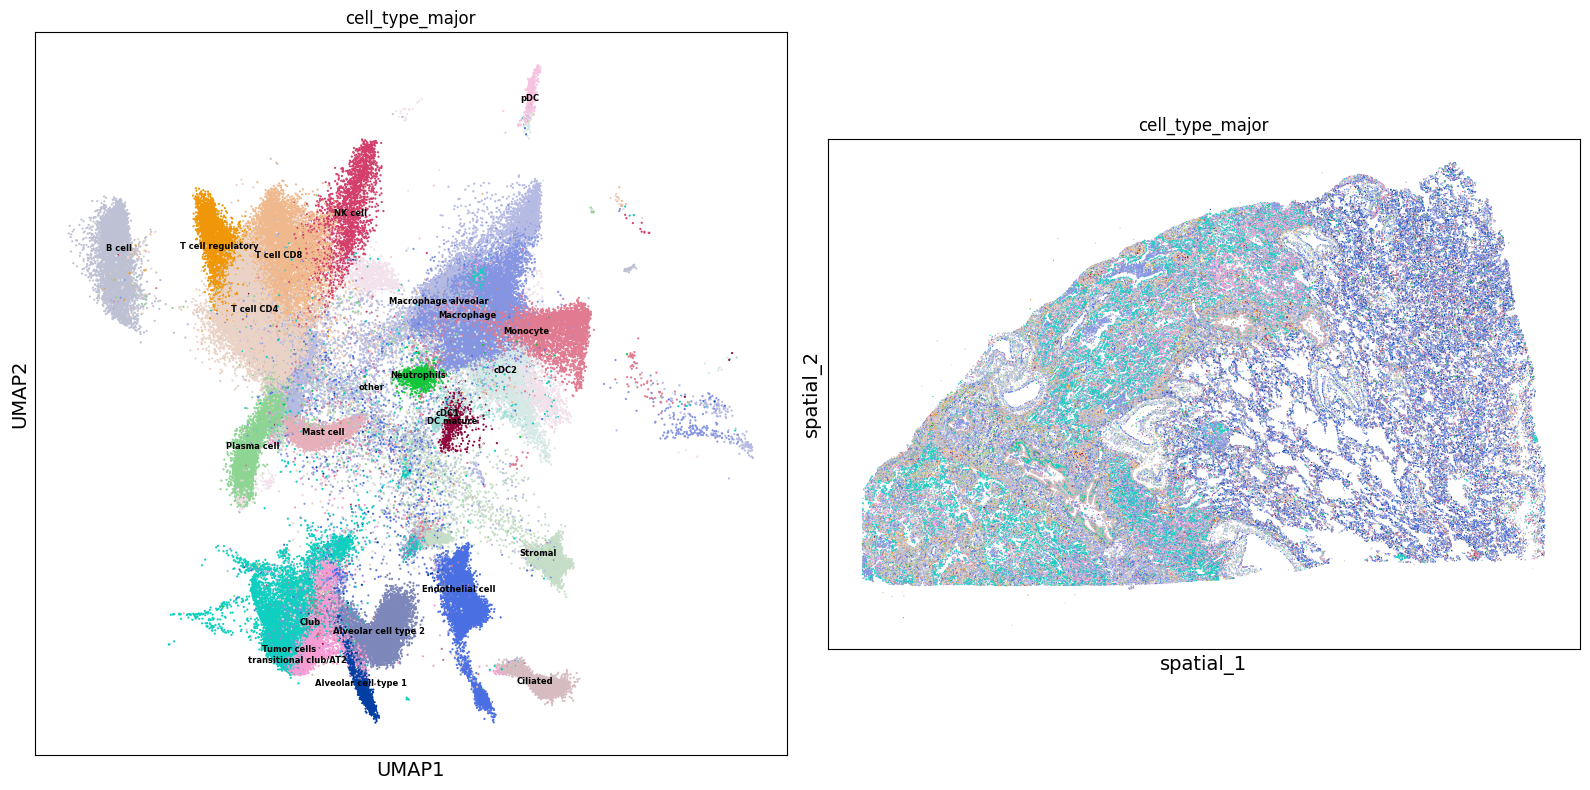

In [10]:
# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot UMAP
sc.pl.umap(
    adata,
    color="cell_type_major",
    legend_loc='on data', 
    wspace=0.2,
    alpha=1.0,
    size=10,
    legend_fontsize=6,
    ax=ax1,
    show=False
)
ax1.set_xlabel('UMAP1', fontsize=14)
ax1.set_ylabel('UMAP2', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot Spatial
sc.pl.spatial(
    adata,
    color="cell_type_major",
    spot_size=20,
    legend_loc=None,
    ax=ax2,
    show=False
)
ax2.set_xlabel('spatial_1', fontsize=14)
ax2.set_ylabel('spatial_2', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


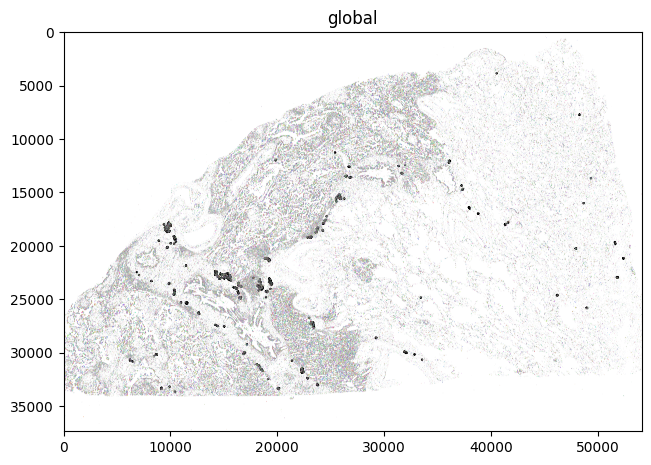

In [14]:
# check anthracosis_regions
sdata.pl.render_shapes("anthracosis_regions", color="black", fill_alpha = 1, outline_alpha=1).pl.render_labels().pl.show()

In [23]:
##### get the list of the anthracosis_regions (geopandas.geodataframe.GeoDataFrame)

# note this is in the "pixel" coordinate system, e.g., POLYGON ((10450 33625, 10450 33626, 10449 3362...

anthracosis_regions = sdata['anthracosis_regions']
anthracosis_regions.iloc[0]


geometry    POLYGON ((10450 33625, 10450 33626, 10449 3362...
Name: poly_0, dtype: geometry

In [28]:

##### get the list of the cell boundries (geopandas.geodataframe.GeoDataFrame)

# note this is in the physical "micro" coordinate system, e.g., POLYGON ((10450 33625, 10450 33626, 10449 3362...
sdata["cell_boundaries"].iloc[:3]

# and need to be transformed to the pixel coordinate system for distance calculation
cell_boundary_in_pixel = transform(sdata["cell_boundaries"].iloc[0:3], to_coordinate_system="global") 
cell_boundary_in_pixel

,geometry
aaaaadnb-1,"POLYGON ((3869 24036, 3868 24037.001, 3862 240..."
aaaabalp-1,"POLYGON ((3963 24214, 3956 24220, 3954 24224, ..."
aaaadfei-1,"POLYGON ((3915 24138.001, 3914 24139, 3907 241..."


In [48]:
# temp cell centroid
temp_cell_centroid_index = cell_boundary_in_pixel.iloc[0].name
temp_cell_centroid = Point(cell_boundary_in_pixel.iloc[0][0].centroid)

# temp polygon 
temp_anthracosis_region = anthracosis_regions.iloc[0][0]

# calculate distance
temp_dist = temp_anthracosis_region.distance(temp_cell_centroid)
temp_dist

/tmp/ipykernel_372/4080411043.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_cell_centroid = Point(cell_boundary_in_pixel.iloc[0][0].centroid)
/tmp/ipykernel_372/4080411043.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_anthracosis_region = anthracosis_regions.iloc[0][0]


11607.826307980486

In [51]:
# information of this cell
adata.obs[adata.obs['cell_id'] == temp_cell_centroid_index]


,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,...,pct_counts_in_top_20_genes,pct_counts_in_top_50_genes,pct_counts_in_top_150_genes,n_counts,leiden,dc_10x,dc_PanglaoDB,dc_10x_cancer,dc_10x_cancer_auc,cell_type_major
0,aaaaadnb-1,226,0,0,0,0,0,226.0,44.659533,21.223438,...,21.681416,39.380531,83.628319,226.0,17,type II pneumocyte,NK cells,mast cell,regulatory T cell,T cell regulatory
